# Import Libraries

In [33]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)

# Load Data

In [3]:
train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')

# EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   prompt                  9912 non-null   object 
 1   essay                   9912 non-null   object 
 2   task_achievement        9667 non-null   float64
 3   coherence_and_cohesion  9614 non-null   float64
 4   lexical_resource        9238 non-null   float64
 5   grammatical_range       9041 non-null   float64
dtypes: float64(4), object(2)
memory usage: 464.8+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  473 non-null    object
 1   essay   473 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [6]:
train['prompt'].nunique()

3506

<Axes: >

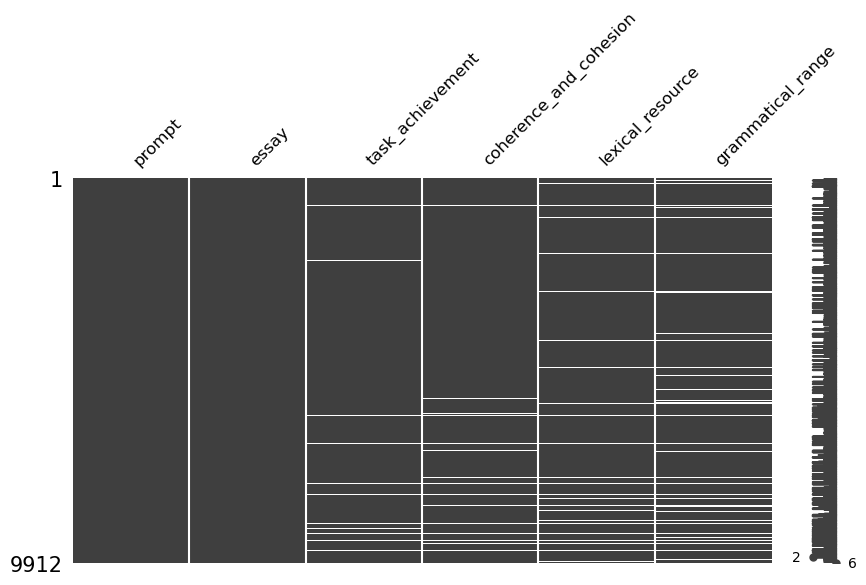

In [7]:
msno.matrix(train, figsize=(10, 5), fontsize=12)

<Axes: >

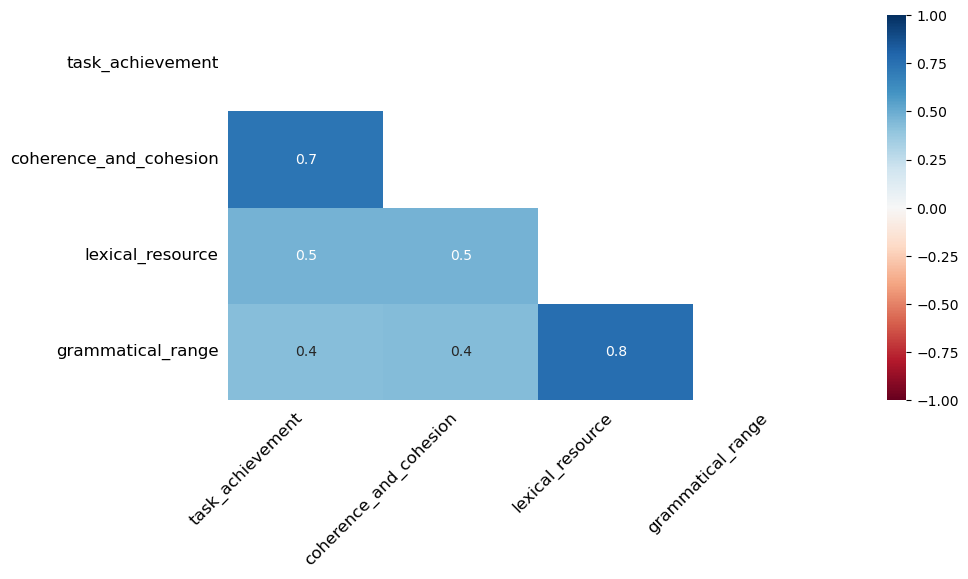

In [8]:
msno.heatmap(train, figsize=(10, 5), fontsize=12)

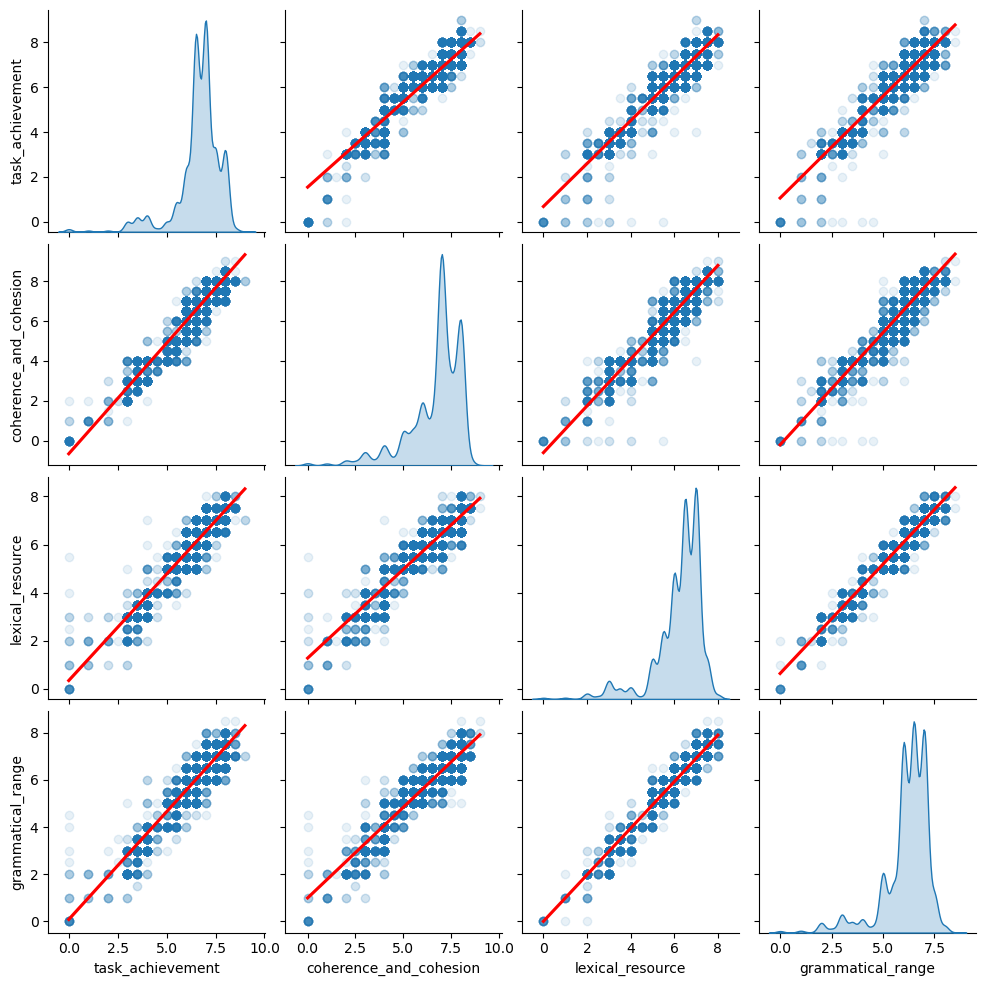

In [9]:
sns.pairplot(train.select_dtypes(include=['float64', 'int64']), diag_kind='kde', kind='reg', plot_kws={'scatter_kws': {'alpha': 0.1}, 'line_kws': {'color': 'red'}})

# Data Preprocessing

In [10]:
# Function to clean text
def clean_text(s):
    return (
        s.str.replace(r'\\[nrt]|\n|\r|\t', ' ', regex=True)  # replace literal and real escapes
         .str.replace(r'\s+', ' ', regex=True)               # collapse multiple spaces
         .str.strip()                                        # remove leading/trailing spaces
         .str.lower()                                        # lowercase
    )

# Apply to train and test
train['essay_under'] = clean_text(train['essay'])
train['prompt_under'] = clean_text(train['prompt'])

test['essay_under'] = clean_text(test['essay'])
test['prompt_under'] = clean_text(test['prompt'])


In [11]:
train['essay_under'][0]

'deciding to choose among the potential ways of punishing young people who commit crimes continues to be a controversial issue for the societies and the governments. it is argued by some that these people should be treated the same as adults. i personally disagree with this opinion due to the adverse effects of imprisonment on a teenager’s mental health. many countries put the criminals of their society at jails considering it as a very effective way of punishment. it is understandable that this does exert a positive influence on decreasing crime in the society by putting the criminals in an unpleasant situation which they would mostly never wish to experience again. as a result, this could impede them from attempting crime in the future. for example, my friend who had been sent to jail for 2 months because of repeatedly committing traffic offends, has never committed the same crime since being released admitting that being in prison had been intolerable for her. however, i believe usi

In [12]:
train['merged_text'] = train['prompt_under'] + ' [SEP] ' + train['essay_under']
test['merged_text'] = test['prompt_under'] + ' [SEP] ' + test['essay_under']

In [13]:
str(train['merged_text'][0])

'young people who commit crimes should be treated in the same way as adults who commit crimes. to what extent do you agree or disagree? [SEP] deciding to choose among the potential ways of punishing young people who commit crimes continues to be a controversial issue for the societies and the governments. it is argued by some that these people should be treated the same as adults. i personally disagree with this opinion due to the adverse effects of imprisonment on a teenager’s mental health. many countries put the criminals of their society at jails considering it as a very effective way of punishment. it is understandable that this does exert a positive influence on decreasing crime in the society by putting the criminals in an unpleasant situation which they would mostly never wish to experience again. as a result, this could impede them from attempting crime in the future. for example, my friend who had been sent to jail for 2 months because of repeatedly committing traffic offends

In [14]:
train_clean = train.dropna()
test_clean = test.dropna()

<Axes: >

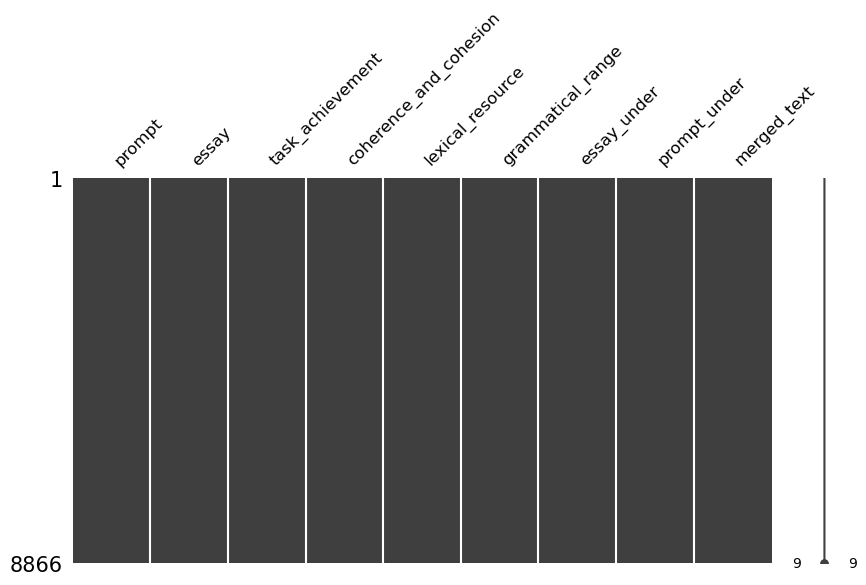

In [15]:
msno.matrix(train_clean, figsize=(10, 5), fontsize=12)

# Modelling

In [ ]:
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
import torch

# Force CPU usage to avoid CUDA compatibility issues
device = 'cpu'

# Embed
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
train_emb = model.encode(train_clean['merged_text'].tolist(), show_progress_bar=True, device=device)
test_emb = model.encode(test_clean['merged_text'].tolist(), show_progress_bar=True, device=device)

Batches:   0%|          | 0/278 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
train_emb.shape, test_emb.shape

((8866, 384), (473, 384))

In [36]:
y_train_merged = train_clean[['task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']].values

X_train, X_val, y_train, y_val = train_test_split(train_emb, y_train_merged, test_size=0.2, random_state=42)

y_train_task_achievement = y_train[:, 0]
y_train_coherence_and_cohesion = y_train[:, 1]
y_train_lexical_resource = y_train[:, 2]
y_train_grammatical_range = y_train[:, 3]

y_val_task_achievement = y_val[:, 0]
y_val_coherence_and_cohesion = y_val[:, 1]
y_val_lexical_resource = y_val[:, 2]
y_val_grammatical_range = y_val[:, 3]

In [39]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

def train_model(X_train, y_train, X_val, y_val, task_name):
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        max_depth=-1,
        random_state=42,
        verbose=-1,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
    )

    mse = mean_squared_error(y_val, model.predict(X_val))
    print(f'Mean Squared Error for {task_name}: {mse}')
    
    return model

task_models = {
    'task_achievement': train_model(X_train, y_train_task_achievement, X_val, y_val_task_achievement, 'Task Achievement'),
    'coherence_and_cohesion': train_model(X_train, y_train_coherence_and_cohesion, X_val, y_val_coherence_and_cohesion, 'Coherence and Cohesion'),
    'lexical_resource': train_model(X_train, y_train_lexical_resource, X_val, y_val_lexical_resource, 'Lexical Resource'),
    'grammatical_range': train_model(X_train, y_train_grammatical_range, X_val, y_val_grammatical_range, 'Grammatical Range')
}

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 1.17132
[200]	valid_0's l2: 1.14372
[300]	valid_0's l2: 1.13185
[400]	valid_0's l2: 1.12294
[500]	valid_0's l2: 1.12055
Early stopping, best iteration is:
[521]	valid_0's l2: 1.12007
Mean Squared Error for Task Achievement: 1.120071242184385
Training until validation scores don't improve for 50 rounds


/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[100]	valid_0's l2: 1.74335
[200]	valid_0's l2: 1.70466
[300]	valid_0's l2: 1.68722
[400]	valid_0's l2: 1.67603
[500]	valid_0's l2: 1.66832
[600]	valid_0's l2: 1.66327
[700]	valid_0's l2: 1.65885
Early stopping, best iteration is:
[723]	valid_0's l2: 1.65733
Mean Squared Error for Coherence and Cohesion: 1.6573342424715907
Training until validation scores don't improve for 50 rounds


/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[100]	valid_0's l2: 1.07988
[200]	valid_0's l2: 1.05827
[300]	valid_0's l2: 1.04296
[400]	valid_0's l2: 1.03536
[500]	valid_0's l2: 1.02817
[600]	valid_0's l2: 1.02649
[700]	valid_0's l2: 1.02374
[800]	valid_0's l2: 1.02286
Early stopping, best iteration is:
[829]	valid_0's l2: 1.0221
Mean Squared Error for Lexical Resource: 1.0220999956824655
Training until validation scores don't improve for 50 rounds


/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[100]	valid_0's l2: 1.17285
[200]	valid_0's l2: 1.14573
[300]	valid_0's l2: 1.13099
[400]	valid_0's l2: 1.12298
[500]	valid_0's l2: 1.11821
[600]	valid_0's l2: 1.11649
Early stopping, best iteration is:
[593]	valid_0's l2: 1.11608
Mean Squared Error for Grammatical Range: 1.1160763841721064


/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [41]:
# predict on test set
predictions = {}
for task, model in task_models.items():
    predictions[task] = model.predict(test_emb)

# Create submission dataframe
submission = pd.DataFrame({
    'ID': range(1, len(test_emb) + 1),
    'task_achievement': predictions['task_achievement'],
    'coherence_and_cohesion': predictions['coherence_and_cohesion'],
    'lexical_resource': predictions['lexical_resource'],
    'grammatical_range': predictions['grammatical_range']
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")
print(submission.head())


Submission file created successfully!
   ID  task_achievement  coherence_and_cohesion  lexical_resource  \
0   1          6.565991                6.338762          5.763445   
1   2          6.835973                6.540113          6.319341   
2   3          6.149388                5.502914          5.314343   
3   4          6.445429                6.591731          5.953429   
4   5          6.733790                7.112431          6.656182   

   grammatical_range  
0           6.159205  
1           6.294314  
2           5.636205  
3           6.114236  
4           6.349414  


/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/mnt/data/Projects/BDC-Internal/.conda/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
